# FEAST 
We will walk through the steps to define, register, and delete features in the **Feast** feature store. The data for this demo is pulled from Kaggle context ad clicks dataaset. 

Preliminary: we need our Kaggle API token for pulling data from Kaggle database to Google Colab. 

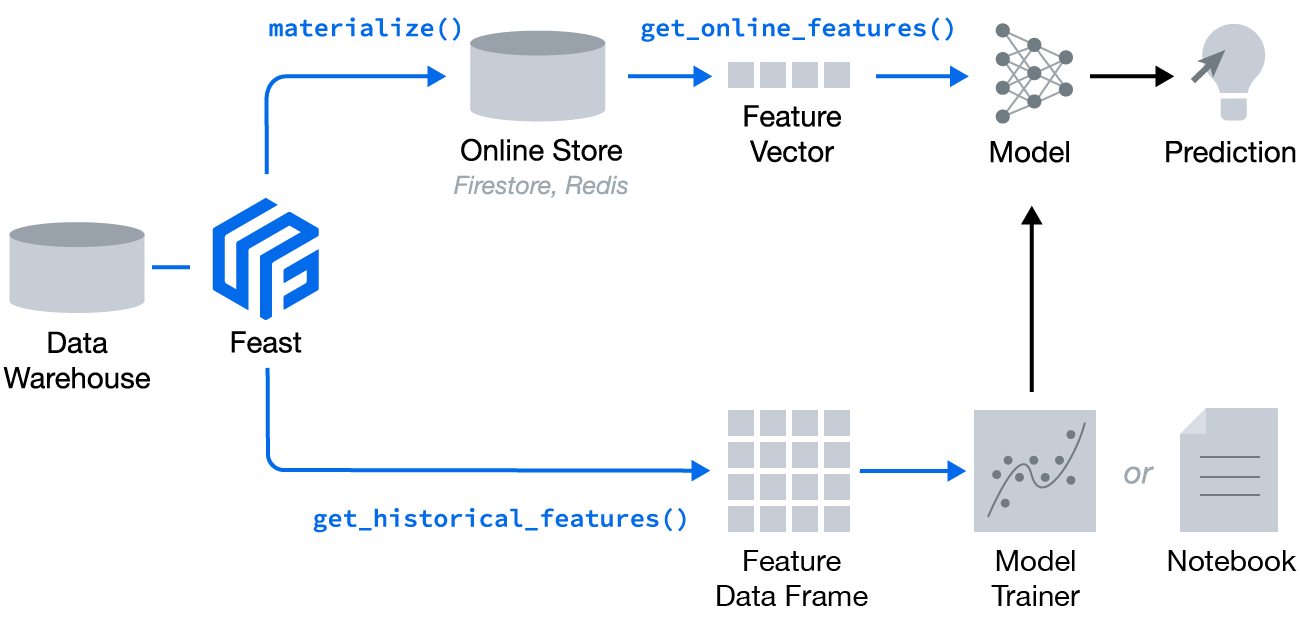

In [ ]:
# Install feast library
!pip install -q feast[gcp]

## Ad-click dataset




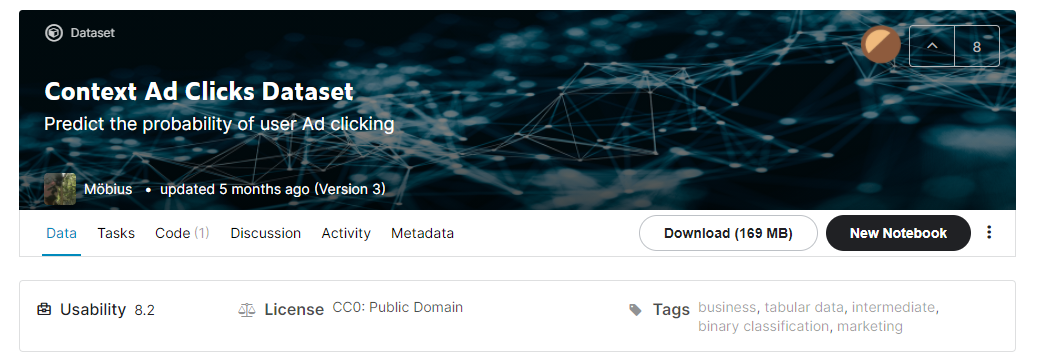

In [3]:
# Mount google drive to Colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Upload kaggle api token
!pip install -q -U kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle
!cp /content/gdrive/MyDrive/Colab/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d arashnic/ctrtest
!unzip ctrtest

In [5]:
# Load libraries
import os
import pandas as pd
from datetime import datetime
from feast import FeatureStore
from feast import Entity, ValueType, Feature, FeatureView
from feast.data_format import ParquetFormat
from feast import FileSource
from google.protobuf.duration_pb2 import Duration

Feast is an open source project that collects anonymized error reporting and usage statistics. To opt out or learn more see https://docs.feast.dev/reference/usage


### Initializing the feature store

In [9]:
%%shell
ls -l
feast init click_data

total 36980
-rw-r--r-- 1 root root 37844491 Sep  4 20:53 ctrtest.zip
drwx------ 6 root root     4096 Sep  4 20:53 gdrive
drwxr-xr-x 1 root root     4096 Aug 31 13:47 sample_data
drwxr-xr-x 2 root root     4096 Sep  4 20:53 sample_submission
drwxr-xr-x 2 root root     4096 Sep  4 20:53 test_ctr
drwxr-xr-x 2 root root     4096 Sep  4 20:53 train_adc

Creating a new Feast repository in /content/click_data.



In [10]:
%cd click_data

/content/click_data


### ETL

In [11]:
%%shell
ls -l ../train_adc

total 163700
-rw-r--r-- 1 root root   3346472 Feb  9  2021 item_data.csv
-rw-r--r-- 1 root root  17681346 Feb  9  2021 train.csv
-rw-r--r-- 1 root root 146595750 Feb  9  2021 view_log.csv


In [14]:
# [1] train.csv
data = pd.read_csv("/content/train_adc/train.csv")
data['impression_time'] = pd.to_datetime(data['impression_time'])
data.to_parquet("./data/train.parquet")
data.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0


In [15]:
# [2] view_log.csv
view_log = pd.read_csv("/content/train_adc/view_log.csv")
view_log['server_time'] = pd.to_datetime(view_log['server_time'])
view_log.to_parquet("./data/view_log.parquet")
view_log.head()

,server_time,device_type,session_id,user_id,item_id
0,2018-10-15 08:58:00,android,112333,4557,32970
1,2018-10-15 08:58:00,android,503590,74788,7640
2,2018-10-15 08:58:00,android,573960,23628,128855
3,2018-10-15 08:58:00,android,121691,2430,12774
4,2018-10-15 08:58:00,android,218564,19227,28296


In [18]:
# [3] item_data.csv
item = pd.read_csv("/content/train_adc/item_data.csv")
item['created_timestamp'] = datetime.now()
item.to_parquet("./data/item_data.parquet")
item.head()

,item_id,item_price,category_1,category_2,category_3,product_type,created_timestamp
0,26880,4602,11,35,20,3040,2022-09-04 21:02:12.075085
1,54939,3513,12,57,85,6822,2022-09-04 21:02:12.075085
2,40383,825,17,8,279,1619,2022-09-04 21:02:12.075085
3,8777,2355,13,58,189,5264,2022-09-04 21:02:12.075085
4,113705,1267,17,39,151,10239,2022-09-04 21:02:12.075085


In [19]:
os.environ["TRAIN_DATA"] = "./data/view_log.parquet"
os.environ["ITEM_DATA"] = "./data/item_data.parquet"
os.environ["VIEW_LOG_DATA"] = "./data/view_log.parquet"

### Re-write the featureTable definition as feature store

In [20]:
class ContextAdClickData:

    def __init__(self) -> None:
        self.features = {}

    def train_view_source(self):
        return FileSource(
            event_timestamp_column="impression_time",
            # created_timestamp_column="created",
            file_format=ParquetFormat(),
            path=os.environ.get("TRAIN_DATA"),
        )
    
    def item_data_view_source(self):
        return FileSource(
            file_format=ParquetFormat(),
            event_timestamp_column="created_timestamp",
            path=os.environ.get("ITEM_DATA")
            # path="s3://{bucket_name}/data/item_data.parquet"
        )
    
    def view_log_data_view_source(self):
        return FileSource(
            event_timestamp_column="server_time",
            file_format=ParquetFormat(),
            path=os.environ.get("VIEW_LOG_DATA")
        )

    def trainView(self):
        """Defines the train table for the click data.
        :params:
            - column_type_dict - A dictionary of columns and the data type
        
        """
        name = "train_table"
        return FeatureView(
            name=name,
            entities=[self.train_entity().name],
            ttl=Duration(seconds=86400 * 1),
            features=[
                # self.feature_create("impression_id", ValueType.STRING),  # Entities should be commented out
                self.feature_create("user_id", ValueType.STRING),
                self.feature_create("app_code", ValueType.INT32),
                self.feature_create("os_version", ValueType.STRING),
                self.feature_create("is_4G", ValueType.INT32),
                self.feature_create("is_click", ValueType.INT32),
            ],
            online=True,
            source=self.train_view_source(),
            tags={}
        )
    
    def viewLogView(self):
        name = "view_log_table"
        return FeatureView(
            name=name,
            entities=[self.view_log_entity().name],
            ttl=Duration(seconds=86400 * 1),
            features=[
                self.feature_create("server_time", ValueType.UNIX_TIMESTAMP),  # Timestamp features should be included
                self.feature_create("device_type", ValueType.STRING),
                # self.feature_create("session_id", ValueType.INT32),  # Entities should be commented out
                self.feature_create("user_id", ValueType.INT64),
                self.feature_create("item_id", ValueType.INT64)
            ],
            online=True,
            source=self.view_log_data_view_source(),
            tags={}
        )

    def itemDataView(self):
        name = "item_data_table"
        feature_table = FeatureView(
            name=name,
            entities=[self.item_data_entity().name],
            ttl=Duration(seconds=86400 * 1),
            features=[
                self.feature_create("item_id", ValueType.INT32),
                self.feature_create("item_price", ValueType.INT32),
                self.feature_create("category_1", ValueType.INT32),
                self.feature_create("category_2", ValueType.INT32),
                self.feature_create("category_3", ValueType.INT32),
                self.feature_create("product_type", ValueType.INT32)
            ],
            online=True,
            source=self.item_data_view_source(),
            tags={}
        )
        return feature_table
        
    
    def train_entity(self):
        name = "impression_id"
        return Entity(name, value_type=ValueType.INT32, description="Impression logs with click details")

    def view_log_entity(self):
        name = "session_id"
        #TODO: Check how to merge the user_id in this entity and user id in click entity.
        return Entity(name=name, value_type=ValueType.INT64, description="View log containing user_id and item_id being viewed")
    
    def item_data_entity(self):
        name="item_id"
        return Entity(name=name, value_type=ValueType.INT32, description="Item data")

    def feature_create(self, name, value):
        """Add features """
        self.features[name] = Feature(name, dtype=value)
        assert name in self.features
        return self.features[name]

### Registering feast objects to local feature store

In [21]:
# Instatiating feast objects
addClick = ContextAdClickData()

en_train = addClick.train_entity()
en_item = addClick.item_data_entity()
en_view_log = addClick.view_log_entity()

x = addClick.trainView()
y = addClick.itemDataView()
z = addClick.viewLogView()

/usr/local/lib/python3.7/dist-packages/feast/entity.py:97: DeprecationWarning: Entity name should be specified as a keyword argument instead of a positional arg.Feast 0.24+ will not support positional arguments to construct Entities
  DeprecationWarning,
/usr/local/lib/python3.7/dist-packages/feast/entity.py:118: DeprecationWarning: The `value_type` parameter is being deprecated. Instead, the type of an entity should be specified as a Field in the schema of a feature view. Feast 0.24 and onwards will not support the `value_type` parameter. The `entities` parameter of feature views should also be changed to a List[Entity] instead of a List[str]; if this is not done, entity columns will be mistakenly interpreted as feature columns.
  DeprecationWarning,
/usr/local/lib/python3.7/dist-packages/feast/data_source.py:255: DeprecationWarning: The argument 'event_timestamp_column' is being deprecated. Please use 'timestamp_field' instead. instead. Feast 0.24 and onwards will not support the arg

In [22]:
store = FeatureStore(repo_path=".")

In [23]:
store.apply([x, en_train]) 
store.apply([y, en_item])
store.apply([z, en_view_log])

### Retrieving data from local store

In [24]:
# Suppose we like to pull the device_type data from view_log_table
# around designated dates.
entity_df = pd.DataFrame.from_dict({
    "session_id": [218564],
    "event_timestamp" : datetime(2018, 10, 15, 8, 58, 00),
})

In [25]:
data_df = store.get_historical_features(
    features=["view_log_table:device_type"], entity_df=entity_df)
ex_data = data_df.to_df()
ex_data.head()

,session_id,event_timestamp,device_type
0,218564,2018-10-15 08:58:00+00:00,android


### Deleting feast objects

For details, please check the API doc: https://rtd.feast.dev/en/v0.19.0/_modules/feast/feature_store.html#FeatureStore

In [26]:
store = FeatureStore(repo_path=".")
store.list_feature_views()

[<FeatureView(name = train_table, entities = ['impression_id'], stream_source = None, batch_source = {
   "type": "BATCH_FILE",
   "timestampField": "impression_time",
   "fileOptions": {
     "fileFormat": {
       "parquetFormat": {}
     },
     "uri": "./data/view_log.parquet"
   },
   "name": "./data/view_log.parquet"
 }, source = {
   "type": "BATCH_FILE",
   "timestampField": "impression_time",
   "fileOptions": {
     "fileFormat": {
       "parquetFormat": {}
     },
     "uri": "./data/view_log.parquet"
   },
   "name": "./data/view_log.parquet"
 }, ttl = 1 day, 0:00:00, schema = [], entity_columns = [impression_id-Int32], features = [user_id-String, app_code-Int32, os_version-String, is_4G-Int32, is_click-Int32], description = , tags = {}, owner = , projection = FeatureViewProjection(name='train_table', name_alias=None, desired_features=[], features=[user_id-String, app_code-Int32, os_version-String, is_4G-Int32, is_click-Int32], join_key_map={}), created_timestamp = 2022-09

In [73]:
for i in store.list_data_sources():
    print(i.name)

./data/view_log.parquet
./data/item_data.parquet


#### Method 1. Using delete_feature_view()

In [38]:
# suppose we like to remove all of these feature views
store.delete_feature_view('item_data_table')
store.delete_feature_view('train_table')
store.delete_feature_view('view_log_table')

In [39]:
# None of them are left.
store.list_feature_views()

[]

In [40]:
# The item_data_table feature view is no loger there.
store.get_feature_view("item_data_table").features

FeatureViewNotFoundException: ignored

In [41]:
# Now we add the train_table feature view back.
store.apply([x,en_train])
# store.apply([y,en_item])  # remove the item table. successfully.
# store.apply([z,en_view_log])

In [42]:
for i in store.list_feature_views():
    print(i.name)

train_table


#### Method 2. Using apply()

In [43]:
# suppose we like to remove the train_table feature view.
# put objects to remove in a list for the second argument.
store.apply([], [x, en_train], partial=False)  

In [44]:
# The feature store is empty again.
for i in store.list_feature_views():
    print(i.name)